In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from IPython.display import Image
np.set_printoptions(precision = 3)

In [2]:
data = pd.read_csv("jester-data-1.csv", header=None)
del data[data.columns[0]]
data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
user_ratings = data.values
user_ratings_vali = np.zeros(user_ratings.shape) + 99.0
user_ratings_copy = user_ratings.copy() 
count = 0
loc_log = []
for x in range(0,user_ratings.shape[0]):
    for y in range(0,user_ratings.shape[1]):
        if (user_ratings_copy[x,y]!=99.0):
            if (np.random.random() > 0.9):
                count += 1
                temp = user_ratings_copy[x,y]
                user_ratings_copy[x,y] = user_ratings_vali[x,y]
                user_ratings_vali[x,y] = temp
                loc_log.append((x,y))
                #print(temp)
print(user_ratings_vali,'\n', count,'\n', count/(user_ratings.shape[0]*user_ratings.shape[1]))

[[99.   99.   -9.66 ... 99.   99.   99.  ]
 [99.   99.   99.   ...  0.34 99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 ...
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]] 
 179993 
 0.0720461914101589


In [5]:
len(loc_log)

179993

In [6]:
n_features = 100
latent_user_preferences = np.random.random((user_ratings.shape[0], n_features))
latent_item_features = np.random.random((user_ratings.shape[1],n_features))

In [7]:
print('user_ratings.shape:           ',user_ratings.shape)
print('latent_user_preferences.shape:',latent_user_preferences.shape)
print('latent_item_features.shape:   ',latent_item_features.shape)

user_ratings.shape:            (24983, 100)
latent_user_preferences.shape: (24983, 100)
latent_item_features.shape:    (100, 100)


In [9]:
user_ratings, user_ratings.shape

(array([[-7.82,  8.79, -9.66, ..., 99.  , 99.  , 99.  ],
        [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        ...,
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [ 2.43,  2.67, -3.98, ..., 99.  , 99.  , 99.  ]]), (24983, 100))

In [10]:
np.random.random()

0.014839811934449054

In [11]:
train_mse_loglist = []
test_mse_loglist = []
best_latent_user_preferences = latent_user_preferences.copy()
best_latent_item_features = latent_item_features.copy()
best_test_mse = 99999.0
best_loc = 0

In [12]:
def predict_rating(user_id,item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)  #linear

def train(user_id, item_id, rating,alpha = 0.0001):
    
    #print (item_id)
    prediction_rating = predict_rating(user_id, item_id)
    err =  ( prediction_rating- rating );
    #print (err)
    user_pref_values = latent_user_preferences[user_id][:]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    


def sgd(iterations = 300000):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    global best_latent_user_preferences
    global best_latent_item_features
    global best_test_mse
    global best_loc
    err_mse_log = 99999.0
    for iteration in range(0,iterations):
        error = []
        vali_err = []
        for user_id in range(0,latent_user_preferences.shape[0]):
            for item_id in range(0,latent_item_features.shape[0]):
                rating = user_ratings_copy[user_id][item_id]
                if(rating != 99):
                    err = train(user_id,item_id,rating)
                    error.append(err)
                    #print(rating)
        mse = (np.array(error) ** 2).mean()
        train_mse_loglist.append(mse)
        err_mse = mse - err_mse_log
        #if (err_mse>0):
        #    print(mse, err_mse, err_mse_log)
        #    break
        err_mse_log = mse
        for loc in loc_log:
            vali_err.append(user_ratings_vali[loc[0]][loc[1]]-latent_user_preferences[loc[0]].dot(latent_item_features[loc[1]]))
        test_mse = (np.array(vali_err) ** 2).mean()
        test_mse_loglist.append(test_mse)
        if (test_mse < best_test_mse):
            best_test_mse = test_mse
            best_latent_user_preferences = latent_user_preferences.copy()
            best_latent_item_features = latent_item_features.copy()
            best_loc = iteration
        if (iteration > best_loc+100):
            break
        #print(iteration)
        #if(iteration%100 == 0 ):
        print (iteration, ':=', mse, err_mse, test_mse)

In [13]:
sgd()

0 := 32.61013548776388 -99966.38986451224 25.2804891645523
1 := 25.23185610091787 -7.378279386846007 25.1563827633991
2 := 25.06966648052503 -0.1621896203928408 25.063709597850753
3 := 24.94235472245296 -0.12731175807206796 24.987880941188372
4 := 24.832977841759625 -0.10937688069333618 24.91701962132754
5 := 24.727208091603035 -0.10576975015658974 24.83978599104171
6 := 24.610932701748137 -0.11627538985489849 24.743581431864147
7 := 24.468267591110187 -0.1426651106379495 24.612977107908247
8 := 24.279970005830553 -0.18829758527963492 24.428583455778366
9 := 24.022744287637956 -0.257225718192597 24.16714730141316
10 := 23.67066429304111 -0.3520799945968456 23.804424862204595
11 := 23.200603886929862 -0.4700604061112479 23.32273950977895
12 := 22.602987301236485 -0.5976165856933768 22.723423886270403
13 := 21.895352698350678 -0.7076346028858076 22.038820380414972
14 := 21.129398382966457 -0.7659543153842208 21.33212967801673
15 := 20.379960672649673 -0.7494377103167835 20.67708379915998

KeyboardInterrupt: 

In [14]:
del train_mse_loglist[0]

In [15]:
best_loc

18

In [16]:
import seaborn as sns

In [17]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(train_mse_loglist).shape[0]), train_mse_loglist)).T, columns=['iterations', 'train_MSE'])

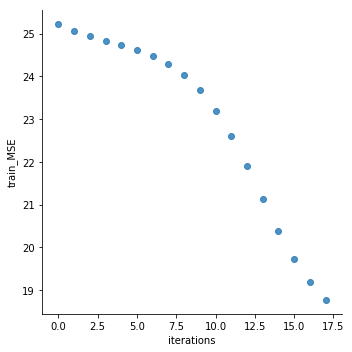

In [18]:
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_trainMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

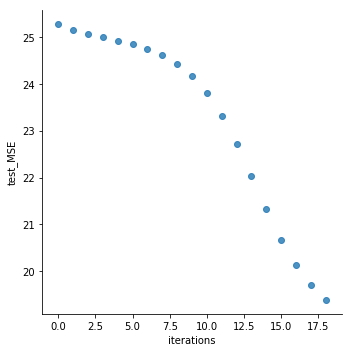

In [19]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(test_mse_loglist).shape[0]), test_mse_loglist)).T, columns=['iterations', 'test_MSE'])
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_testMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

In [20]:
min(test_mse_loglist), test_mse_loglist.index(min(test_mse_loglist)), train_mse_loglist[test_mse_loglist.index(min(test_mse_loglist))+1]

IndexError: list index out of range

In [ ]:
min(train_mse_loglist), train_mse_loglist.index(min(train_mse_loglist)),

In [ ]:
predictions = best_latent_user_preferences.dot(best_latent_item_features.T)
predictions

In [ ]:
err = []
for t in range(0, len(loc_log)):
    #print(predictions[loc_log[t][0],loc_log[t][1]], best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]]), user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
    err.append(best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]])-user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
mse2 = (np.array(err) ** 2).mean()
print(mse2)

In [ ]:
vali_err = []
for loc in loc_log:
    vali_err.append(user_ratings_vali[loc[0]][loc[1]]-best_latent_user_preferences[loc[0]].dot(best_latent_item_features[loc[1]]))
test_mse = (np.array(vali_err) ** 2).mean()
print (test_mse)

In [ ]:
best_test_mse

In [ ]:
values = [zip(user_ratings_copy[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: "(%2.3f|%2.3f)"%(x[0],x[1]))

In [ ]:
values = [zip(user_ratings_vali[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: ["(%2.3f|%2.3f)"%(x[0],x[1])])

In [ ]:
mse

In [ ]:
predictions

In [ ]:
latent_item_features

In [ ]:
np.savetxt("Fulltext_predictions_%df_%d.csv"%(n_features, best_loc), predictions, delimiter=",")
np.savetxt("Fulltext_latent_user_preferences_%df_%d.csv"%(n_features, best_loc), best_latent_user_preferences, delimiter=",")
np.savetxt("Fulltextlatent_item_features_%df_%d.csv"%(n_features, best_loc), best_latent_item_features, delimiter=",")